# Project 4:    Melanoma Classification

# Abstract
---
### Purpose of research
1. Analyse and classify Melanoma datasets, including metadata and image datasets), which are provided on Kaggle plateform https://www.kaggle.com/c/siim-isic-melanoma-classification
2. find the best algorithm to build module and predict the probability of condition of Melanoma (benign or malignant) based on test metadata and images.
3. the result is evaluated on AOC (area under the ROC curve) between the predicted probability and the observed target.

### Working procedure
1. EDA
2. Data Preprocessing
3. Model build
4. Training Tuning, and predicting


### Summary of findings
1. Extreme Label Imbalance: more than 98% percent of images in training data is labelled as "Benign", and less than 2% (500) images are labelled as "Malignant". Therefore, we implement several strategies to reduce the imbalance, such as sampling "Benign" images and generating new "Malignant" images.
2. Both metadata and images can be used for model building respectively, and also combining both datasets together to build a hybird model.
3. If only Metadata involved, KNN will not obtain a valuable result when using AOC evaluation method, but RandomForest will obtain a plausible prediction on probability. The RandomForest predict result (score) will be the baseline to estimate other algorithms and models in this project.
4. Deeplearning and tons of features will not guarente better result, in this particular project,  CNN + Lightgbm only get 0.61 score, less than RandomForest with only Metadata.
5. Thus, feature selection and image processing is critical for imbalance class.

# Introduction
This project is an response for an active competition on Kaggle plateform. 
https://www.kaggle.com/c/siim-isic-melanoma-classification

The purpose of this competition is to identify and classify melanoma, a deadly skin cancer. The competition is lanchued by the Society for Imaging Informatics in Medicine (SIIM) and the International Skin Imaging Collaboration (ISIC), an international effort to improve melanoma diagnosis. 

In this project, we follow the instruction on Kaggle, and build several models to predict the probability of melanoma diagnosis on given datasets. The materials provided by the orgnasition are metadata which includes patient basic information and the result of diagnosis, and images which are high resolutional pictures of melanoma.

In [5]:
import glob
import numpy as np
import pandas as pd
import os
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import multiprocessing as mp
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.optimizers import Adam
from tensorflow.keras import optimizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import Callback
import tensorflow as tf

In [6]:
random.seed = 42

In [3]:
train_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/train.csv")
test_df = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/test.csv")
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [5]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10982 entries, 0 to 10981
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     10982 non-null  object 
 1   patient_id                     10982 non-null  object 
 2   sex                            10982 non-null  object 
 3   age_approx                     10982 non-null  float64
 4   anatom_site_general_challenge  10631 non-null  object 
dtypes: float64(1), object(4)
memory usage: 429.1+ KB


In [7]:
train_df.nunique()

image_name                       33126
patient_id                        2056
sex                                  2
age_approx                          18
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
target                               2
dtype: int64

In [8]:
test_df.nunique()

image_name                       10982
patient_id                         690
sex                                  2
age_approx                          17
anatom_site_general_challenge        6
dtype: int64

## Insight
1. Missing vaules

Both metadata and image files show the the total number of train images is 33126. In metadata, some columns has some missing values (NaN), namely sex, age_approx and anatom_site_general_challenge.
On the other hand, only "anatom_site_general_challenge" in the test data has missing values.

Handling missing values will be done before model building and training. Several choices we can choose (drop or fill values), but before we make decision, let's acquire more detail about the columns first.

2. Unique values
    
    1) one patient may have muliple images in the datasets.
 
    2) "benign_malignant" and "target" are both binary classification, they are what we need to predict, thus, "benign_malignant" should not be included in features.

## target distribution

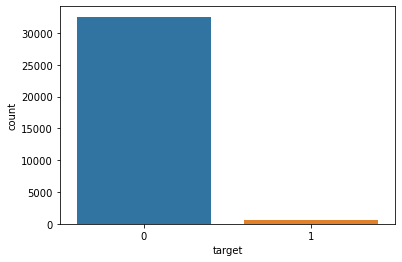

In [9]:
sns.countplot(train_df['target'])

## Insight
* This step helps us to find out the target values (Y values) distribution.

* the classification of this datasets is binary - it has shown by the nunique function, it is worthy to note that the distribution of target values in training sample is extremely imbalance: 99% of the target value is zero. 

* This extreme imbalance of Y values may cause a dilemma：
    * you will get a good validating accuracy, (validation dataset is a randomly selected subset of training dataset, it is reasonable to assume that randomly guess may get >90% accuracy), but the test datasets may differ from the traning dataset and the test accuracy is low;
    * or you will get both high validating accuracy and test accuracy - the problem is any algorithm will do the same thing.
    * the real problem is that it makes more hard to identify malignant melanoma, because the corresponding samples are too few to identify features. 
* Therefore, having too many benign samples does not help us to identify maliganant melanoma. This may imply that we could reduce benign samples to reduce overfitting issue. And we will reduce benign samples in training sections.

## Age,Sex and melanoma distribution

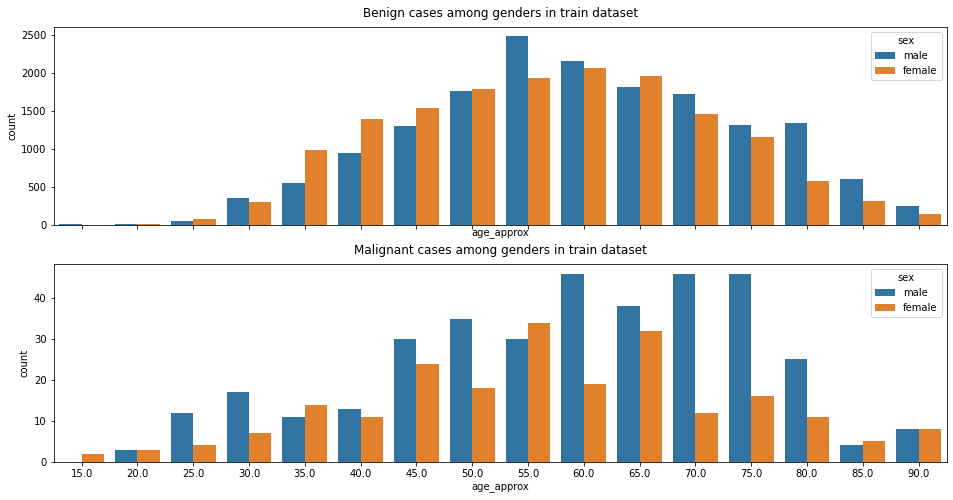

In [10]:
fig, ax = plt.subplots(2,1, figsize=(16,8), sharex=True)

cond1 = train_df.benign_malignant == 'benign'
cond2 = train_df.benign_malignant == 'malignant'
#sns.countplot('age_approx',hue='sex', data=train_df)
#sns.barplot('age_approx', 'target', 'sex', data=train_df)
sns.countplot(train_df['age_approx'].where(cond1), hue=train_df.sex, ax=ax[0])
ax[0].set_title("Benign cases among genders in train dataset", pad=10)

sns.countplot(train_df['age_approx'].where(cond2), hue=train_df.sex, ax=ax[1])
ax[1].set_title("Malignant cases among genders in train dataset", pad=10)
plt.show()

## Insight
* It is obvious that age plays a key role in melanoma diagnoses. Males in (60,75) seems to be risky in malignant tumor while Females in 55 and 65 are the most risky group.

* As for sex, it seems that males have more risk than females to have malignant tumor.
 
* It also noticable that males in (45,50) have a relatively high potential of developing a malignant tumor. We could speculate that besides age and sex, there would be other effects cause the high ratios for males in such early ages.

## Anatom site distribution analysis

In [11]:
train_df['anatom_site_general_challenge'].where(cond1).value_counts()

torso              16588
lower extremity     8293
upper extremity     4872
head/neck           1781
palms/soles          370
oral/genital         120
Name: anatom_site_general_challenge, dtype: int64

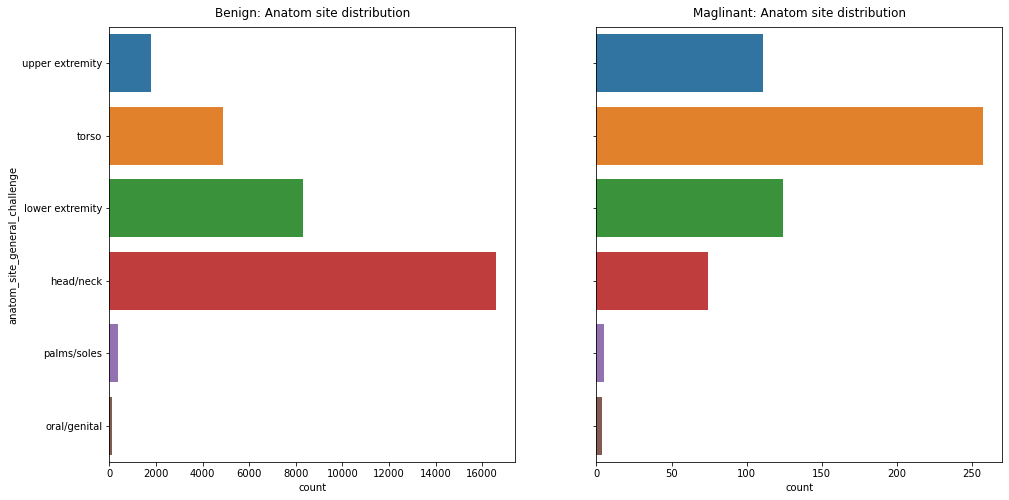

In [12]:
fig, ax = plt.subplots(1,2, figsize=(16,8), sharey=True)
#train_df['anatom_site_general_challenge'].where(cond1).value_counts()
sns.countplot(y=train_df['anatom_site_general_challenge'].where(cond1),ax=ax[0])
ax[0].set_title("Benign: Anatom site distribution", pad=10)
#train_df['anatom_site_general_challenge'].where(cond2).value_counts()
sns.countplot(y=train_df['anatom_site_general_challenge'].where(cond2),ax=ax[1])
ax[1].set_title("Maglinant: Anatom site distribution", pad=10)
ax[1].label_outer()

## Insight
* ”anatom_site_general_challenge“ represent the position of melanoma on patients. As the two parellel graphs shows, "torso" is the part of body which has high potential of maglinant skin cancer compare to other parts. 

* it seems that the most of melanoma images are locatet at "head/neck", but more than 99% of the melanomas are benign in training set.

* it should be reminded that some of rows in ”anatom_site_general_challenge“ column is missed (null.)

## diagnosis and result
The last feature column in training dataset is "diagnosis" (which is not in test dataset), we will explore the relationship between diagnosis and the final result.

total kinds of diagnosis: 9
list of diagnosis: ['unknown' 'nevus' 'melanoma' 'seborrheic keratosis' 'lentigo NOS'
 'lichenoid keratosis' 'solar lentigo' 'cafe-au-lait macule'
 'atypical melanocytic proliferation']

Benign diagonsis distribution:
 unknown                               27124
nevus                                  5193
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64


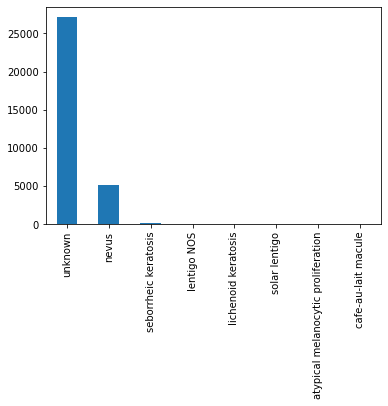

In [13]:
print("total kinds of diagnosis:", len(train_df['diagnosis'].unique()))
print("list of diagnosis:", train_df['diagnosis'].unique())
print("\nBenign diagonsis distribution:\n", train_df['diagnosis'].where(cond1).value_counts())
train_df['diagnosis'].where(cond1).value_counts().plot(kind='bar')

melanoma    584
Name: diagnosis, dtype: int64


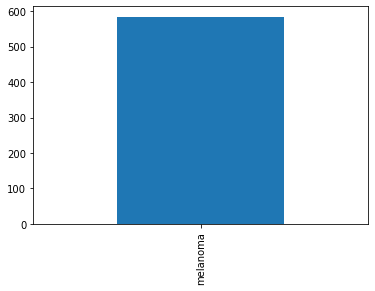

In [14]:
print(train_df['diagnosis'].where(cond2).value_counts())
train_df['diagnosis'].where(cond2).value_counts().plot(kind='bar')

## Insight
* Well, it seems that all the "melanona" is diagnosed as "malignant";
* In the "benign" result, most of the diagnoses are "unknown", this does not make any sense.

# Shallow learning
## Data Propreccessing
In this section, we will begin with handling missing values and encoding the category columns:
* first step is handling missing values. Since test data also has  missing value, we cannot simply drop all the NaN rows. In this case, we can fill with the most common one;
* "age_approx" is a numerical column, what we need to do is normalisation, we will use MinMaxScaler to normalise the column
* regarding category columns: "sex", "anatom_site_general_challenge", we have explore that those two columns have correlation with the target diagnose result. we will use different encoding for the two columns:

    * "sex", is a binary classification, we will use conditional expression to convert boolean results to numerical results;
    * "anatom_site_general_challenge", only have 6 unique values and those values we think are equally important, so we wil try "OneHotEncoder".

### Training metadata preprocessing

In [15]:
### setup training baseline dataframe
train_df_baseline = train_df.copy()

# randomly select a certain number of samples labelled as "benign"
def random_selection(df1, df2, k_samples=10000):
    random_index = random.sample(df1.index.to_list(), k_samples)
    random_df = df1.loc[random_index]
    select_df = pd.concat([random_df, df2])
    select_df.sort_index(inplace=True)
    return select_df

malignant_train_df = train_df[cond2]
benign_train_df = train_df[cond1]

train_df_baseline = random_selection(df1=benign_train_df, df2=malignant_train_df)

In [16]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce

# 
features = ["sex", "age_approx", "anatom_site_general_challenge"]
# fill missing values with most frequent value 
impute = SimpleImputer(strategy='most_frequent')
train_df_baseline[features] = impute.fit_transform(train_df_baseline[features])


# Encoding category columns
# Encoding "sex" column
train_df_baseline = train_df_baseline.assign(sex_enc=(train_df_baseline.sex == 'male').astype('int'))

# Encoding "anatom_site_general_challenge" column
oneHot_enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
oneHot_encoded = oneHot_enc.fit_transform(train_df_baseline['anatom_site_general_challenge'].values.reshape(-1,1))
oneHot_df = pd.DataFrame(oneHot_encoded, index=train_df_baseline.index)
train_df_baseline = train_df_baseline.join(oneHot_df)

# Encoding "age_approx" column with LableEncoding 
# label_enc = LabelEncoder()
# label_encoded = label_enc.fit_transform(train_df_baseline['age_approx'])

#Normilise new "age" column
scaler = MinMaxScaler()
train_df_baseline['age_enc'] = scaler.fit_transform(train_df_baseline['age_approx'].values.reshape(-1,1))


print(train_df_baseline.shape)
train_df_baseline.head()

(10584, 16)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,sex_enc,0,1,2,3,4,5,age_enc
12,ISIC_0076995,IP_2235340,female,55.0,torso,nevus,benign,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.611111
13,ISIC_0077472,IP_3691360,female,40.0,torso,unknown,benign,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.444444
17,ISIC_0079038,IP_5295861,male,70.0,torso,unknown,benign,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.777778
18,ISIC_0080512,IP_1870306,male,75.0,torso,unknown,benign,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.833333
22,ISIC_0082348,IP_7684360,male,55.0,torso,unknown,benign,0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.611111


### test metadata preprocessing

In [17]:
test_df_baseline = test_df.copy()
test_df_baseline[features] = impute.transform(test_df_baseline[features])

test_df_baseline = test_df_baseline.assign(sex_enc=(test_df_baseline.sex == 'male').astype('int'))

oneHot_encoded = oneHot_enc.transform(test_df_baseline['anatom_site_general_challenge'].values.reshape(-1,1))
oneHot_df = pd.DataFrame(oneHot_encoded, index=test_df_baseline.index)
test_df_baseline = test_df_baseline.join(oneHot_df)

test_df_baseline['age_enc'] = scaler.transform(test_df_baseline['age_approx'].values.reshape(-1,1))

print(test_df_baseline.shape)
test_df_baseline.head()

(10982, 13)


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,0,1,2,3,4,5,age_enc
0,ISIC_0052060,IP_3579794,male,70.0,torso,1,0.0,0.0,0.0,0.0,1.0,0.0,0.777778
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.0,1.0,0.0,0.0,0.0,0.0,0.444444
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.0,0.0,0.0,0.0,1.0,0.0,0.611111
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.0,0.0,0.0,0.0,1.0,0.0,0.555556
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.0,1.0,0.0,0.0,0.0,0.0,0.500000


# data training and prediction

* In this section we will try to use only metadata for traning, setup a baseline of result

In [18]:
### At first, we will use KNN to predict the test dataset 
from sklearn.neighbors import KNeighborsClassifier

baseline_features = train_df_baseline.columns[-8:].to_list()
trainX = train_df_baseline[baseline_features]
trainY = train_df_baseline['target']
testX = test_df_baseline[baseline_features]

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn.fit(trainX, trainY)
knn.predict_proba(testX)
#### KNN is not suitable for this compitition because the result is amost binary

array([[1. , 0. ],
       [1. , 0. ],
       [0.8, 0.2],
       ...,
       [0.8, 0.2],
       [1. , 0. ],
       [1. , 0. ]])

In [19]:
# RandomForest is a baseline of results (submission result 0.679)

from sklearn.ensemble import RandomForestClassifier

baseline_features = train_df_baseline.columns[-8:].to_list()
trainX = train_df_baseline[baseline_features]
trainY = train_df_baseline['target']
testX = test_df_baseline[baseline_features]

rfclass = RandomForestClassifier(random_state=42)

rfclass.fit(trainX, trainY)
rfc_predict = rfclass.predict_proba(testX)[:,1]
test_df_baseline['rfc_pred'] = rfc_predict
test_df_baseline.head(2)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,0,1,2,3,4,5,age_enc,rfc_pred
0,ISIC_0052060,IP_3579794,male,70.0,torso,1,0.0,0.0,0.0,0.0,1.0,0.0,0.777778,0.103706
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.0,1.0,0.0,0.0,0.0,0.0,0.444444,0.022922


# Deep Learning Section

In [20]:
train_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/train/'
test_path = '/kaggle/input/siim-isic-melanoma-classification/jpeg/test/'

train_files = glob.glob(train_path+"*") 
test_files = glob.glob(test_path+"*") 
print('Number of train images: %d \nNumber of test images:%d' %(len(train_files), len(test_files)))

Number of train images: 33126 
Number of test images:10982


In [21]:
X_train_image, X_val_image, Y_train_image, Y_val_image = train_test_split(train_df_baseline['image_name'], train_df_baseline['benign_malignant'], random_state=42)

In [22]:
image_df_train = train_df_baseline.loc[X_train_image.index, ['image_name', 'benign_malignant']]
image_df_train['image_name'] = image_df_train['image_name'] + '.jpg'
image_df_train.sort_index(inplace=True)
print(image_df_train.shape)
image_df_train.head(2)

(7938, 2)


,image_name,benign_malignant
13,ISIC_0077472.jpg,benign
17,ISIC_0079038.jpg,benign


In [23]:
image_df_valid = train_df_baseline.loc[X_val_image.index, ['image_name', 'benign_malignant']]
image_df_valid['image_name'] = image_df_valid['image_name'] + '.jpg'
image_df_valid.sort_index(inplace=True)
print(image_df_valid.shape)
image_df_valid.head(2)

(2646, 2)


,image_name,benign_malignant
12,ISIC_0076995.jpg,benign
18,ISIC_0080512.jpg,benign


In [24]:
image_df_test = test_df_baseline[['image_name']] + '.jpg'
print(image_df_test.shape)
image_df_test.head(2)

(10982, 1)


,image_name
0,ISIC_0052060.jpg
1,ISIC_0052349.jpg


In [25]:
###### from keras.applications import mobilenet_v2 
from keras.applications import mobilenet_v2

imageDG = ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
#imageDG = ImageDataGenerator(rescale=1.0/255)
train_batches = imageDG.flow_from_dataframe(dataframe=image_df_train, directory=train_path, x_col='image_name', y_col='benign_malignant', \
                                            target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)

valid_batches = imageDG.flow_from_dataframe(dataframe=image_df_valid, directory=train_path, x_col='image_name', y_col='benign_malignant', \
                                            target_size=(224,224), classes=['benign', 'malignant'], batch_size=32)

test_batches = imageDG.flow_from_dataframe(dataframe=image_df_test, directory=test_path, x_col='image_name', \
                                           target_size=(224,224), shuffle=False, classes=None, class_mode=None, batch_size=32)

Found 7938 validated image filenames belonging to 2 classes.
Found 2646 validated image filenames belonging to 2 classes.
Found 10982 validated image filenames.


### Here we have already generated the train, valid and test batches for CNN training, validating and prediction, notice that we use the preprocessing function from mobilenet_v2, we will use the pre-trained mobilenet_v2 module to build our image training model.
### Before building the model, we will first ensure that our image can be plotted correctly, the plotImages function is directly copy from Tensorflow documentation: https://www.tensorflow.org/tutorials/images/classification#visualize_training_images

In [26]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

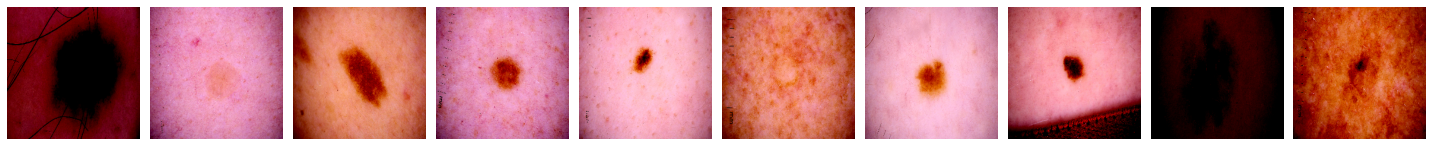

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [27]:
imgs, labels= next(train_batches)
plotImages(imgs)
print(labels[:10])

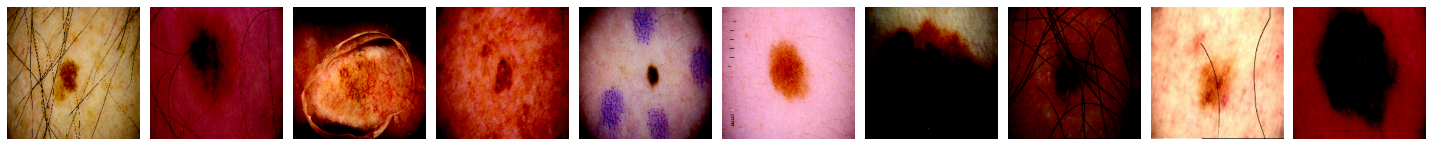

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [28]:
imgs, labels= next(valid_batches)
plotImages(imgs)
print(labels[:10])

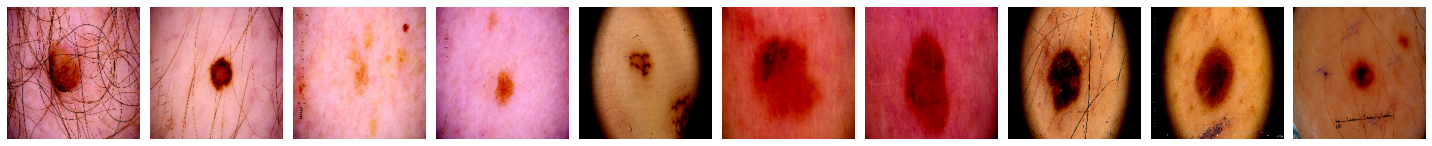

In [29]:
imgs= next(test_batches)
plotImages(imgs)

## Insight
* Well, we are not doctors, we cann't identify whether the melanoma shown in each image is benign or malignant;
* However, we can identify some general atrributes: 
    * all melanoma is centre-located in images
    * label all images for Supervised Learning 

* Beside that, we can ensure that we are on the right path: all the image load in generator and no images left behind, the train images have been seperated into training and validation set
s and then can be used for training and validation, the batches of images in three sets can be plotted correctly.

# Deep Learning Model

* As we mentioned above, we will use the exist MobileNetV2 model to build our own model to reduce the training time and also the model is a pre-trained model have many layers and tuned parameters which are much better than simple CNN model build from scratch.

In [31]:

mobile = mobilenet_v2.MobileNetV2()
print("type of mobilenet_v2 model:", type(mobile))

14540800/14536120 [==============================] - 0s 0us/step
type of mobilenet_v2 model: <class 'keras.engine.training.Model'>


In [32]:
#transfer learning
from keras import Model
output = Dense(units=2, activation='softmax')(mobile.layers[-2].output)
model = Model(inputs=mobile.input, outputs=output)
for layer in model.layers[:-1]:
    layer.trainable = False
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

* Since the orignal MobileNetV2 model has 1000 final ouput, which obviously is not suitable for us (we only have two), we will substitute our own layer for the last layer of vgg16 model.
* To achive the purpose, we will duplicate MobileNetV2 model expect the last layer.
* Notice that the pre-trained parameters will be set as "not trainable", which means, the parameters will not be tuned while training our new model.

In [33]:
# check if GPU is available to use for tensorflow
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

Num GPUs Available:  1


In [34]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
model.fit_generator(train_batches, validation_data=valid_batches, epochs=2, \
                                   steps_per_epoch=len(train_batches), validation_steps=len(valid_batches), \
                                   workers=mp.cpu_count(), use_multiprocessing=True, verbose=1)

Epoch 1/2


/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 61 could not be retrieved. It could be because a worker has died.
  UserWarning)


  4/249 [..............................] - ETA: 1:53:25 - loss: 0.6665 - accuracy: 0.6797

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 4 could not be retrieved. It could be because a worker has died.
  UserWarning)


248/249 [============================>.] - ETA: 12s - loss: 0.2174 - accuracy: 0.9404

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 11 could not be retrieved. It could be because a worker has died.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 14 could not be retrieved. It could be because a worker has died.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 18 could not be retrieved. It could be because a worker has died.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 24 could not be retrieved. It could be because a worker has died.
  UserWarning)


249/249 [==============================] - 3990s 16s/step - loss: 0.2174 - accuracy: 0.9404 - val_loss: 1.1471 - val_accuracy: 0.9410
Epoch 2/2
 11/249 [>.............................] - ETA: 18s - loss: 0.1519 - accuracy: 0.9545

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 152 could not be retrieved. It could be because a worker has died.
  UserWarning)


 19/249 [=>............................] - ETA: 37:28 - loss: 0.1770 - accuracy: 0.9408

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 81 could not be retrieved. It could be because a worker has died.
  UserWarning)


248/249 [============================>.] - ETA: 11s - loss: 0.1807 - accuracy: 0.9451

/opt/conda/lib/python3.7/site-packages/keras/utils/data_utils.py:616: UserWarning: The input 16 could not be retrieved. It could be because a worker has died.
  UserWarning)


249/249 [==============================] - 3728s 15s/step - loss: 0.1802 - accuracy: 0.9453 - val_loss: 0.1614 - val_accuracy: 0.9414


In [36]:
image_feature_train = model.predict(train_batches, workers=mp.cpu_count(), use_multiprocessing=True, verbose=1)
print(image_feature_train.shape)

249/249 [==============================] - 2799s 11s/step
(7938, 2)


In [37]:
image_feature_valid = model.predict(valid_batches, workers=mp.cpu_count(), use_multiprocessing=True, verbose=1)
print(image_feature_valid.shape)

83/83 [==============================] - 928s 11s/step
(2646, 2)


In [38]:
image_feature_test = model.predict(test_batches, workers=mp.cpu_count(), use_multiprocessing=True, verbose=1)
print(image_feature_test.shape)

344/344 [==============================] - 3350s 10s/step
(10982, 2)


In [39]:
cols = [f'imft_{num}' for num in range(image_feature_train.shape[1])]
train_feature_df = pd.DataFrame(image_feature_train, columns=cols, index=image_df_train.index)
valid_feature_df = pd.DataFrame(image_feature_valid, columns=cols, index=image_df_valid.index)
test_feature_df = pd.DataFrame(image_feature_test, columns=cols, index=image_df_test.index)

In [40]:
train_X_final = pd.concat([train_feature_df,train_df_baseline.loc[image_df_train.index, baseline_features]], axis=1)
valid_X_final = pd.concat([valid_feature_df,train_df_baseline.loc[image_df_valid.index, baseline_features]], axis=1)
test_X_final = pd.concat([test_feature_df,test_df_baseline.loc[image_df_test.index, baseline_features]], axis=1)

In [41]:
image_df_train.shape

(7938, 2)

In [44]:
import lightgbm as lgb
dtrain = lgb.Dataset(data=train_X_final, label=train_df_baseline.loc[image_df_train.index, 'target'])
dvalid = lgb.Dataset(data=valid_X_final, label=train_df_baseline.loc[image_df_valid.index, 'target'])

param = {'num_leaves': 64, 'objective': 'binary', 'metric': 'auc'}
num_boost_round = 1000

bst = lgb.train(param, dtrain, num_boost_round, dvalid, early_stopping_rounds=10, verbose_eval=True)

[1]	valid_0's auc: 0.623479
Training until validation scores don't improve for 10 rounds
[2]	valid_0's auc: 0.620782
[3]	valid_0's auc: 0.612216
[4]	valid_0's auc: 0.604608
[5]	valid_0's auc: 0.602437
[6]	valid_0's auc: 0.60477
[7]	valid_0's auc: 0.604777
[8]	valid_0's auc: 0.60142
[9]	valid_0's auc: 0.60663
[10]	valid_0's auc: 0.608808
[11]	valid_0's auc: 0.609669
Early stopping, best iteration is:
[1]	valid_0's auc: 0.623479


In [46]:
target_pred = bst.predict(test_X_final)
test_df_baseline['lgb_pred'] = target_pred
#compare the first few rows of predict results between RandomForest and CNN+LGB 
test_df_baseline.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,0,1,2,3,4,5,age_enc,rfc_pred,lgb_pred
0,ISIC_0052060,IP_3579794,male,70.0,torso,1,0.0,0.0,0.0,0.0,1.0,0.0,0.777778,0.103706,0.056888
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.0,1.0,0.0,0.0,0.0,0.0,0.444444,0.022922,0.052168
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.0,0.0,0.0,0.0,1.0,0.0,0.611111,0.048987,0.052117
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.0,0.0,0.0,0.0,1.0,0.0,0.555556,0.024505,0.050863
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.0,1.0,0.0,0.0,0.0,0.0,0.500000,0.022386,0.050863


In [47]:
# In case the order of "image_name" in sample_submission.csv is not the same as in test.csv 
ss = pd.read_csv("/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv")
ss = ss.merge(test_df_baseline[['image_name', 'lgb_pred']], on='image_name')

upload = ss[['image_name', 'lgb_pred']]
upload.columns = ['image_name', 'target']


upload.to_csv('submission.csv', index=False)
upload.head()

,image_name,target
0,ISIC_0052060,0.056888
1,ISIC_0052349,0.052168
2,ISIC_0058510,0.052117
3,ISIC_0073313,0.050863
4,ISIC_0073502,0.050863
